In [70]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from typing import List

In [71]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# COVID-19 Daily Observation Data

Data from [2019 Novel Coronavirus COVID-19 (2019-nCoV) Data repository](https://github.com/CSSEGISandData/COVID-19) by Johns Hopkins CSSE.

## Load data
We're going to read in all of the data in the [csse_covid_19_daily_reports](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports) directory, and aggregate it into a single `DataFrame`.

First, the dates across the files aren't in a consistent format, so we need a utility to normalize our dates:

In [72]:
def extract_month_day(date: str) -> str:
    """Given a date in multiple possible formats, return m/d formatted date."""
    patterns = [
        r"0?(\d+)/0?(\d+)/\d{2,4} \d{1,2}:\d{2}", # E.g., 1/22/2020 17:00, 01/22/2020 02:00
        r"\d{4}-0?(\d{1,2})-0?(\d{1,2})[T\s]\d{2}:\d{2}:\d{2}", # E.g., 2020-02-02T23:43:02, 2020-03-23 23:19:34
    ]
    for pattern in patterns:
        vals = re.findall(pattern, date)
        if vals:
            return "{}/{}".format(vals[0][0],vals[0][1])
    raise Exception("Failed to extract month/day, bad string format: {}".format(date))

assert extract_month_day("1/22/2020 17:00") == "1/22"
assert extract_month_day("01/22/2020 02:00") == "1/22"
assert extract_month_day("2020-02-02T23:43:02") == "2/2"
assert extract_month_day("2020-03-23 23:19:34") == "3/23"

There are a couple more utilities we need to read in the data:

In [73]:
def list_source_files(dir_name: str) -> List[str]: 
    """Returns a list of all the source files."""
    pattern = r"(\d{2}-\d{2}-\d{4}).csv"
    src = "{}/*.csv".format(dir_name)
    files = [f for f in glob.glob(src) if re.search(pattern, f)]
    files.sort()
    return files

def read_combined_daily_data(file_names: List[str], rename_cols_map):
    """Reads in all the data, combines it in single DataFrame."""
    # Note handling inconsistent column names
    dfs = [pd.read_csv(f).rename(columns=rename_cols_map) for f in files] 
    data = pd.concat(dfs)
    return data

Now we can read in the data, aggregate it, and clean it up:

In [75]:
DIR = "csse_covid_19_daily_reports"

RENAME_COLS = { 'Country_Region': 'Country/Region', 'Province_State': 'Province/State', 
          'Last_Update': 'Last Update'}

# Read in data as single DataFrame
files = list_source_files(DIR)
data = read_combined_daily_data(files, RENAME_COLS)

# Cleanup: select columns NaN -> 0
NUMERIC_COLS = ['Confirmed', 'Deaths', 'Recovered']
data[NUMERIC_COLS] = data[NUMERIC_COLS].fillna(0)
    
# Cleanup: drop anything without cases (removes an error for DC data)
data = data[data['Confirmed'] > 0]

# Cleanup: Augment data with normalized "Date" field
data['Date'] = data['Last Update'].apply(extract_month_day)

# TODO: we shouldn't need two date columns
COLUMNS_TO_KEEP = ['Province/State', 'Country/Region', 'Last Update', 'Date', 'Confirmed', 'Deaths', 'Recovered']

# Cleanup: remove unused columns
data = data[COLUMNS_TO_KEEP]

data

,Province/State,Country/Region,Last Update,Date,Confirmed,Deaths,Recovered
0,Anhui,Mainland China,1/22/2020 17:00,1/22,1.0,0.0,0.0
1,Beijing,Mainland China,1/22/2020 17:00,1/22,14.0,0.0,0.0
2,Chongqing,Mainland China,1/22/2020 17:00,1/22,6.0,0.0,0.0
3,Fujian,Mainland China,1/22/2020 17:00,1/22,1.0,0.0,0.0
5,Guangdong,Mainland China,1/22/2020 17:00,1/22,26.0,0.0,0.0
...,...,...,...,...,...,...,...
3416,NaN,Venezuela,2020-03-26 23:48:18,3/26,107.0,0.0,15.0
3417,NaN,Vietnam,2020-03-26 23:48:18,3/26,153.0,0.0,20.0
3418,NaN,West Bank and Gaza,2020-03-26 23:48:18,3/26,84.0,1.0,17.0
3419,NaN,Zambia,2020-03-26 23:48:18,3/26,16.0,0.0,0.0


## Region-specific cumulative data

Hubei cumulative confirmed cases:

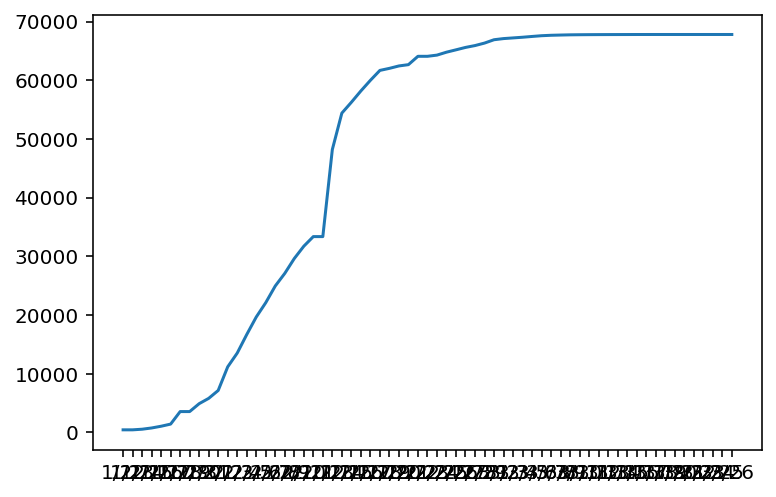

In [50]:
dc = data.loc[data['Province/State'] == 'Hubei']
plt.plot(dc['Date'], dc['Confirmed'])
plt.show()

DC cumulative confirmed cases:

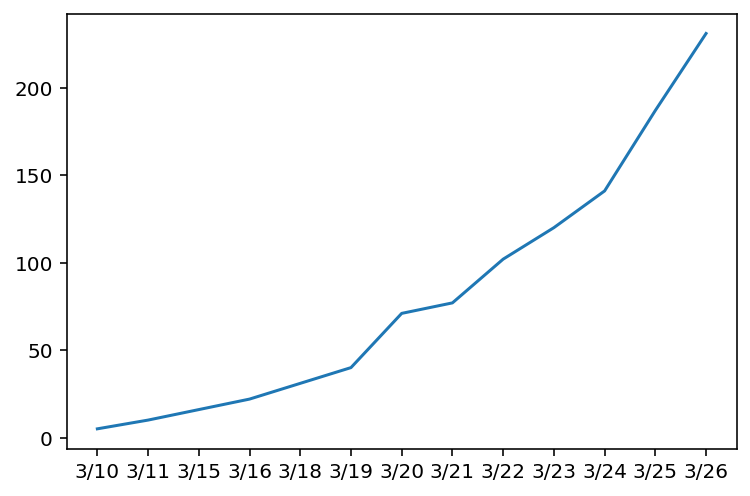

In [51]:
dc = data.loc[data['Province/State'] == 'District of Columbia']
plt.plot(dc['Date'], dc['Confirmed'])
plt.show()